# 전체 데이터 OLS 분석

# 아웃라이어 확인

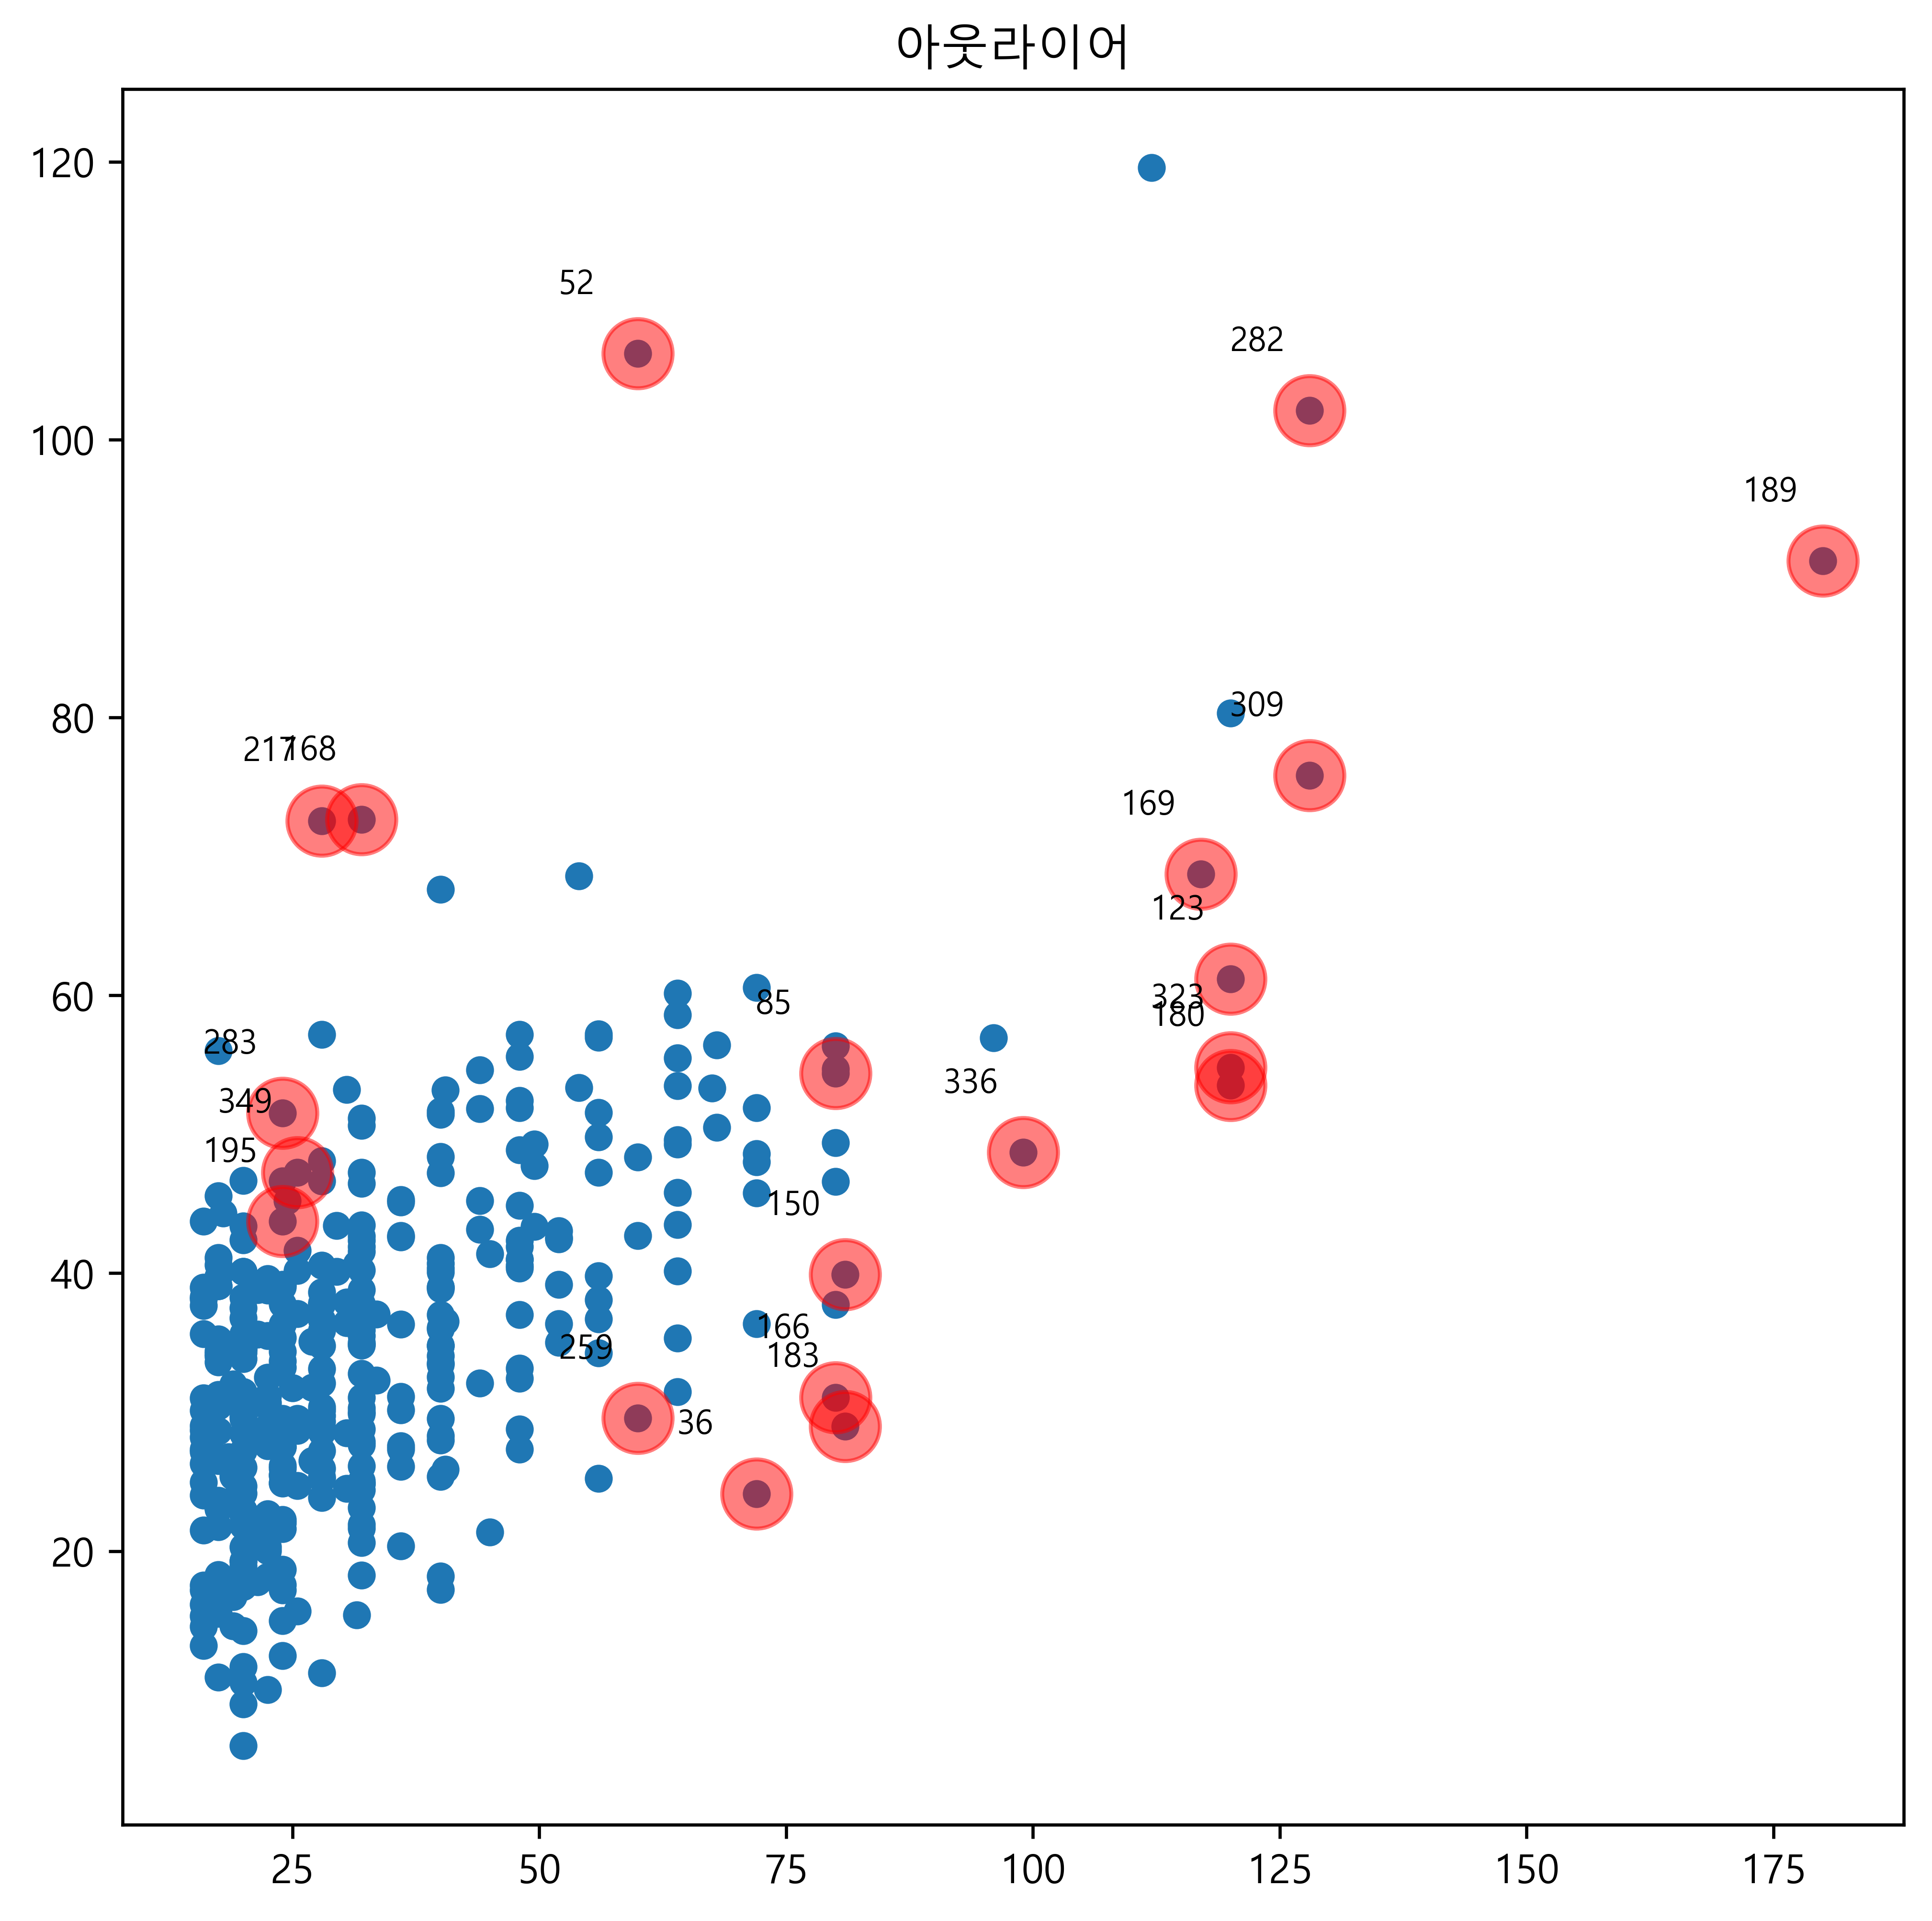

[ 36  52  85 123 150 166 168 169 180 183 189 195 217 259 282 283 309 323
 336 349]


In [6]:
from statsmodels.graphics import utils

dfX0 = df_ols.drop('value', axis=1)
dfX = sm.add_constant(dfX0)
dfy = df_ols['value']

model_p = sm.OLS(dfy, dfX)
result_p = model_p.fit()
pred = result_p.predict(dfX)

influence_p = result_p.get_influence()
cooks_d2, pvals = influence_p.cooks_distance
K = influence_p.k_vars
fox_cr = 4 / (len(dfy) - K - 1)
idx = np.where(cooks_d2 > fox_cr)[0]

ax = plt.subplot()
plt.scatter(dfy, pred)
plt.scatter(dfy[idx], pred[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, list(zip(dfy[idx], pred[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.title("아웃라이어")
plt.show()
print(idx)

# 아웃라이어 제거

In [7]:
idx2 = list(set(range(len(dfX))).difference(idx))
df_out = df_ols.iloc[idx2].reset_index(drop=True)

# 아웃라이어 제거 후, OLS

In [8]:
from sklearn.model_selection import train_test_split

dfX = df_out.drop(['value'], axis=1)
dfy = df_out['value']
df = pd.concat([dfX, dfy], axis=1)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)

feature_names = list(dfX.columns)
feature_names = ["scale({})".format(name) for name in feature_names]

model = sm.OLS.from_formula("value ~ " + "+".join(feature_names), data=df_train)
result = model.fit()
print(result.summary())

pred = result.predict(df_test)

rss = ((df_test.value - pred) ** 2).sum()
tss = ((df_test.value - df_test.value.mean()) ** 2).sum()
rsquared = 1 - rss / tss
rsquared

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     6.675
Date:                Wed, 24 Jun 2020   Prob (F-statistic):           6.57e-17
Time:                        17:19:45   Log-Likelihood:                -943.41
No. Observations:                 245   AIC:                             1943.
Df Residuals:                     217   BIC:                             2041.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

0.428758806890296

# VIF Factor 확인

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif.sort_values(by='VIF Factor', ascending=False)

,VIF Factor,features
18,168.340850,games_lineups
1,114.777359,age
19,48.141862,games_played
2,41.385453,rating
5,28.546988,passes_accuracy
0,21.820481,position
10,18.356539,fouls_committed
4,17.160414,passes_total
8,13.108061,tackles_interceptions
11,10.571770,cards_yellow


# 큰 P값 feature 제거 - 20차

# Final

In [48]:
df_out_20 = df_out_19.drop(['fouls_drawn'], axis=1)
len(df_out_19.columns), len(df_out_20.columns)

(7, 6)

In [68]:
from sklearn.model_selection import train_test_split

dfX = df_out_20.drop(['value'], axis=1)
dfy = df_out_20['value']
df = pd.concat([dfX, dfy], axis=1)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)

feature_names = list(dfX.columns)
feature_names = ["scale({})".format(name) for name in feature_names]

formula = "value ~ " + "+".join(feature_names)

model = sm.OLS.from_formula(formula, data=df_train)
result = model.fit()
print(result.summary())

##############################################################################
from sklearn.model_selection import KFold

scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df_ols)):
    df_train = df_ols.iloc[idx_train]
    df_test = df_ols.iloc[idx_test]
    
    model = sm.OLS.from_formula(formula, data=df_train)
    result = model.fit()
    
    pred = result.predict(df_test)
    rss = ((df_test.value - pred) ** 2).sum()
    tss = ((df_test.value - df_test.value.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
#    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
print("모델 성능 : {}".format(scores.mean()))

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     27.11
Date:                Wed, 24 Jun 2020   Prob (F-statistic):           1.07e-21
Time:                        17:27:23   Log-Likelihood:                -962.44
No. Observations:                 245   AIC:                             1937.
Df Residuals:                     239   BIC:                             1958.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [50]:
sm.stats.anova_lm(result)

,df,sum_sq,mean_sq,F,PR(>F)
scale(age),1.0,134.229737,134.229737,0.356530,5.508516e-01
scale(follower),1.0,26213.193704,26213.193704,69.625350,2.021134e-15
scale(passes_accuracy),1.0,22.018184,22.018184,0.058483,8.090612e-01
scale(games_played),1.0,8903.721718,8903.721718,23.649341,1.796660e-06
scale(shotsOnTotal_goalsTotal),1.0,7552.469769,7552.469769,20.060255,1.037433e-05
Residual,328.0,123488.463446,376.489218,NaN,NaN


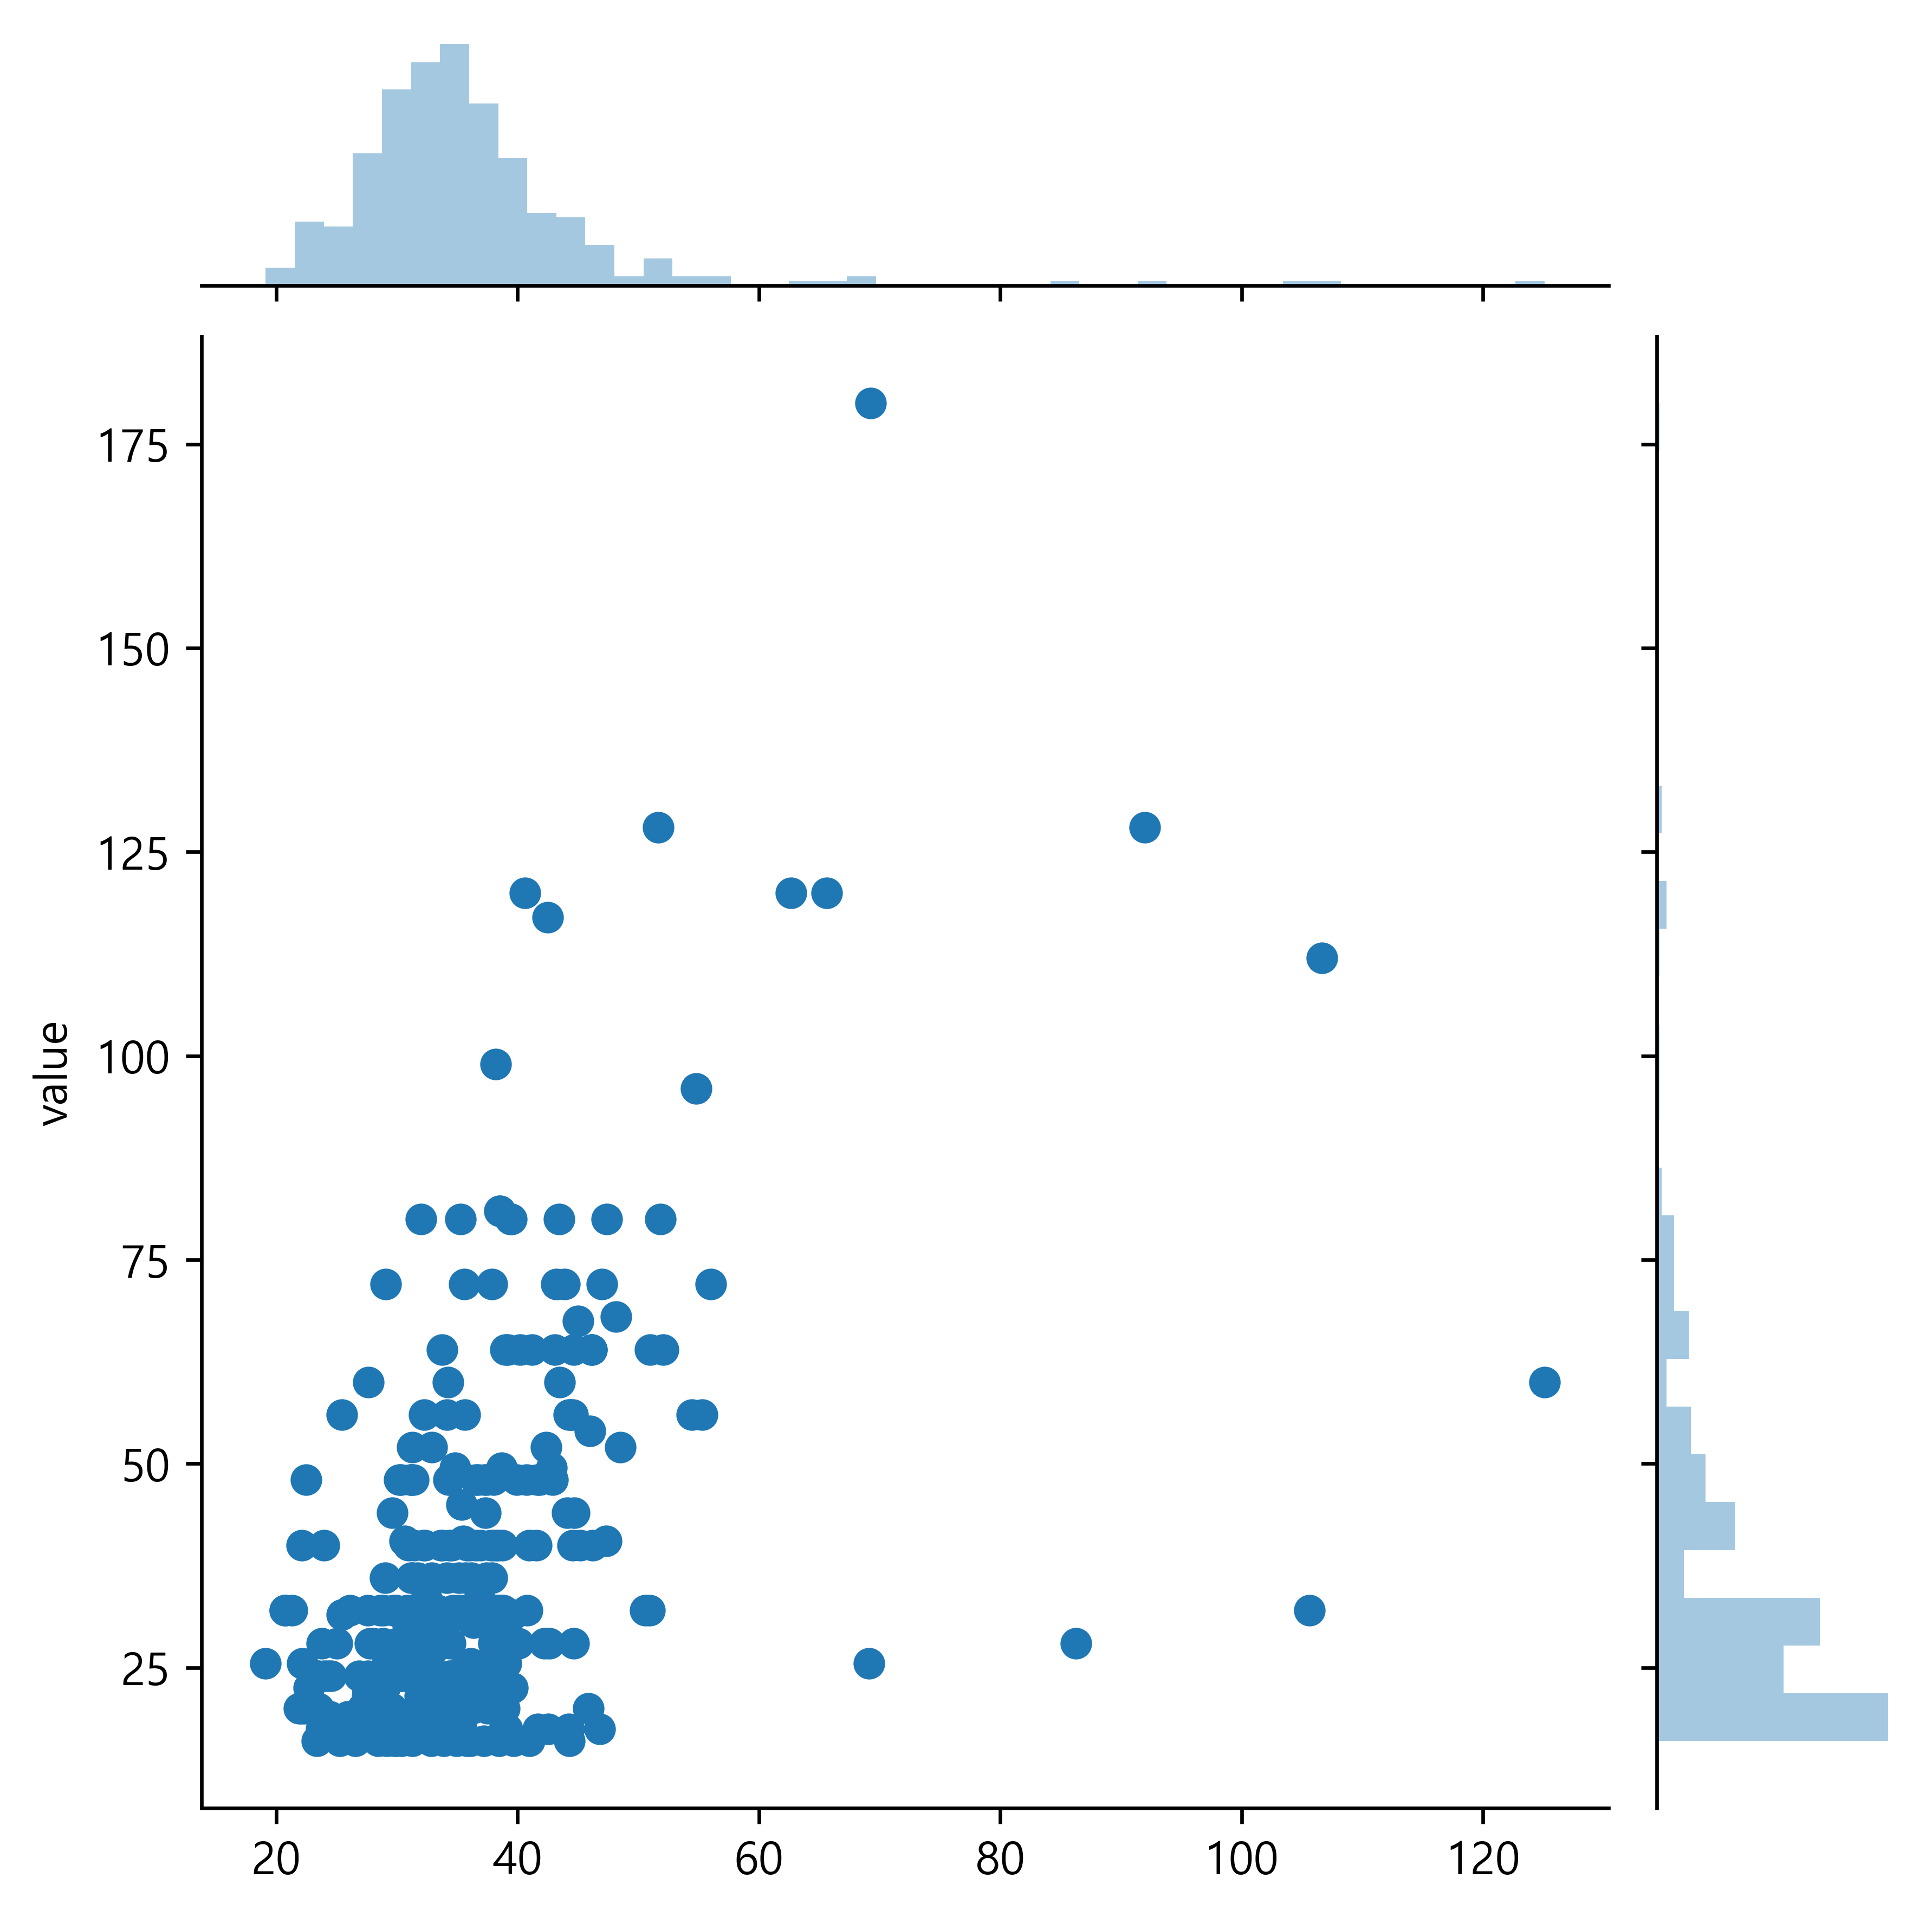

In [51]:
sns.jointplot(result.fittedvalues, df_train.value)
plt.show()

# 검증

In [53]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm

class StatsmodelsOLS(BaseEstimator, RegressorMixin):
    def __init__(self, formula):
        self.formula = formula
        self.model = None
        self.data = None
        self.result = None
        
    def fit(self, dfX, dfy):
        self.data = pd.concat([dfX, dfy], axis=1)
        self.model = smf.ols(self.formula, data=self.data)
        self.result = self.model.fit()
        
    def predict(self, new_data):
        return self.result.predict(new_data)

In [54]:
from sklearn.model_selection import cross_val_score

model = StatsmodelsOLS("value ~ scale(age) + scale(follower) + scale(passes_accuracy) + \
                       scale(games_played) + scale(shotsOnTotal_goalsTotal)")
cv = KFold(10, shuffle=True, random_state=0)
cross_val_score(model, dfX, dfy, scoring="r2", cv=cv).mean()

0.3075559319985198

# 아웃라이어 2차 제거

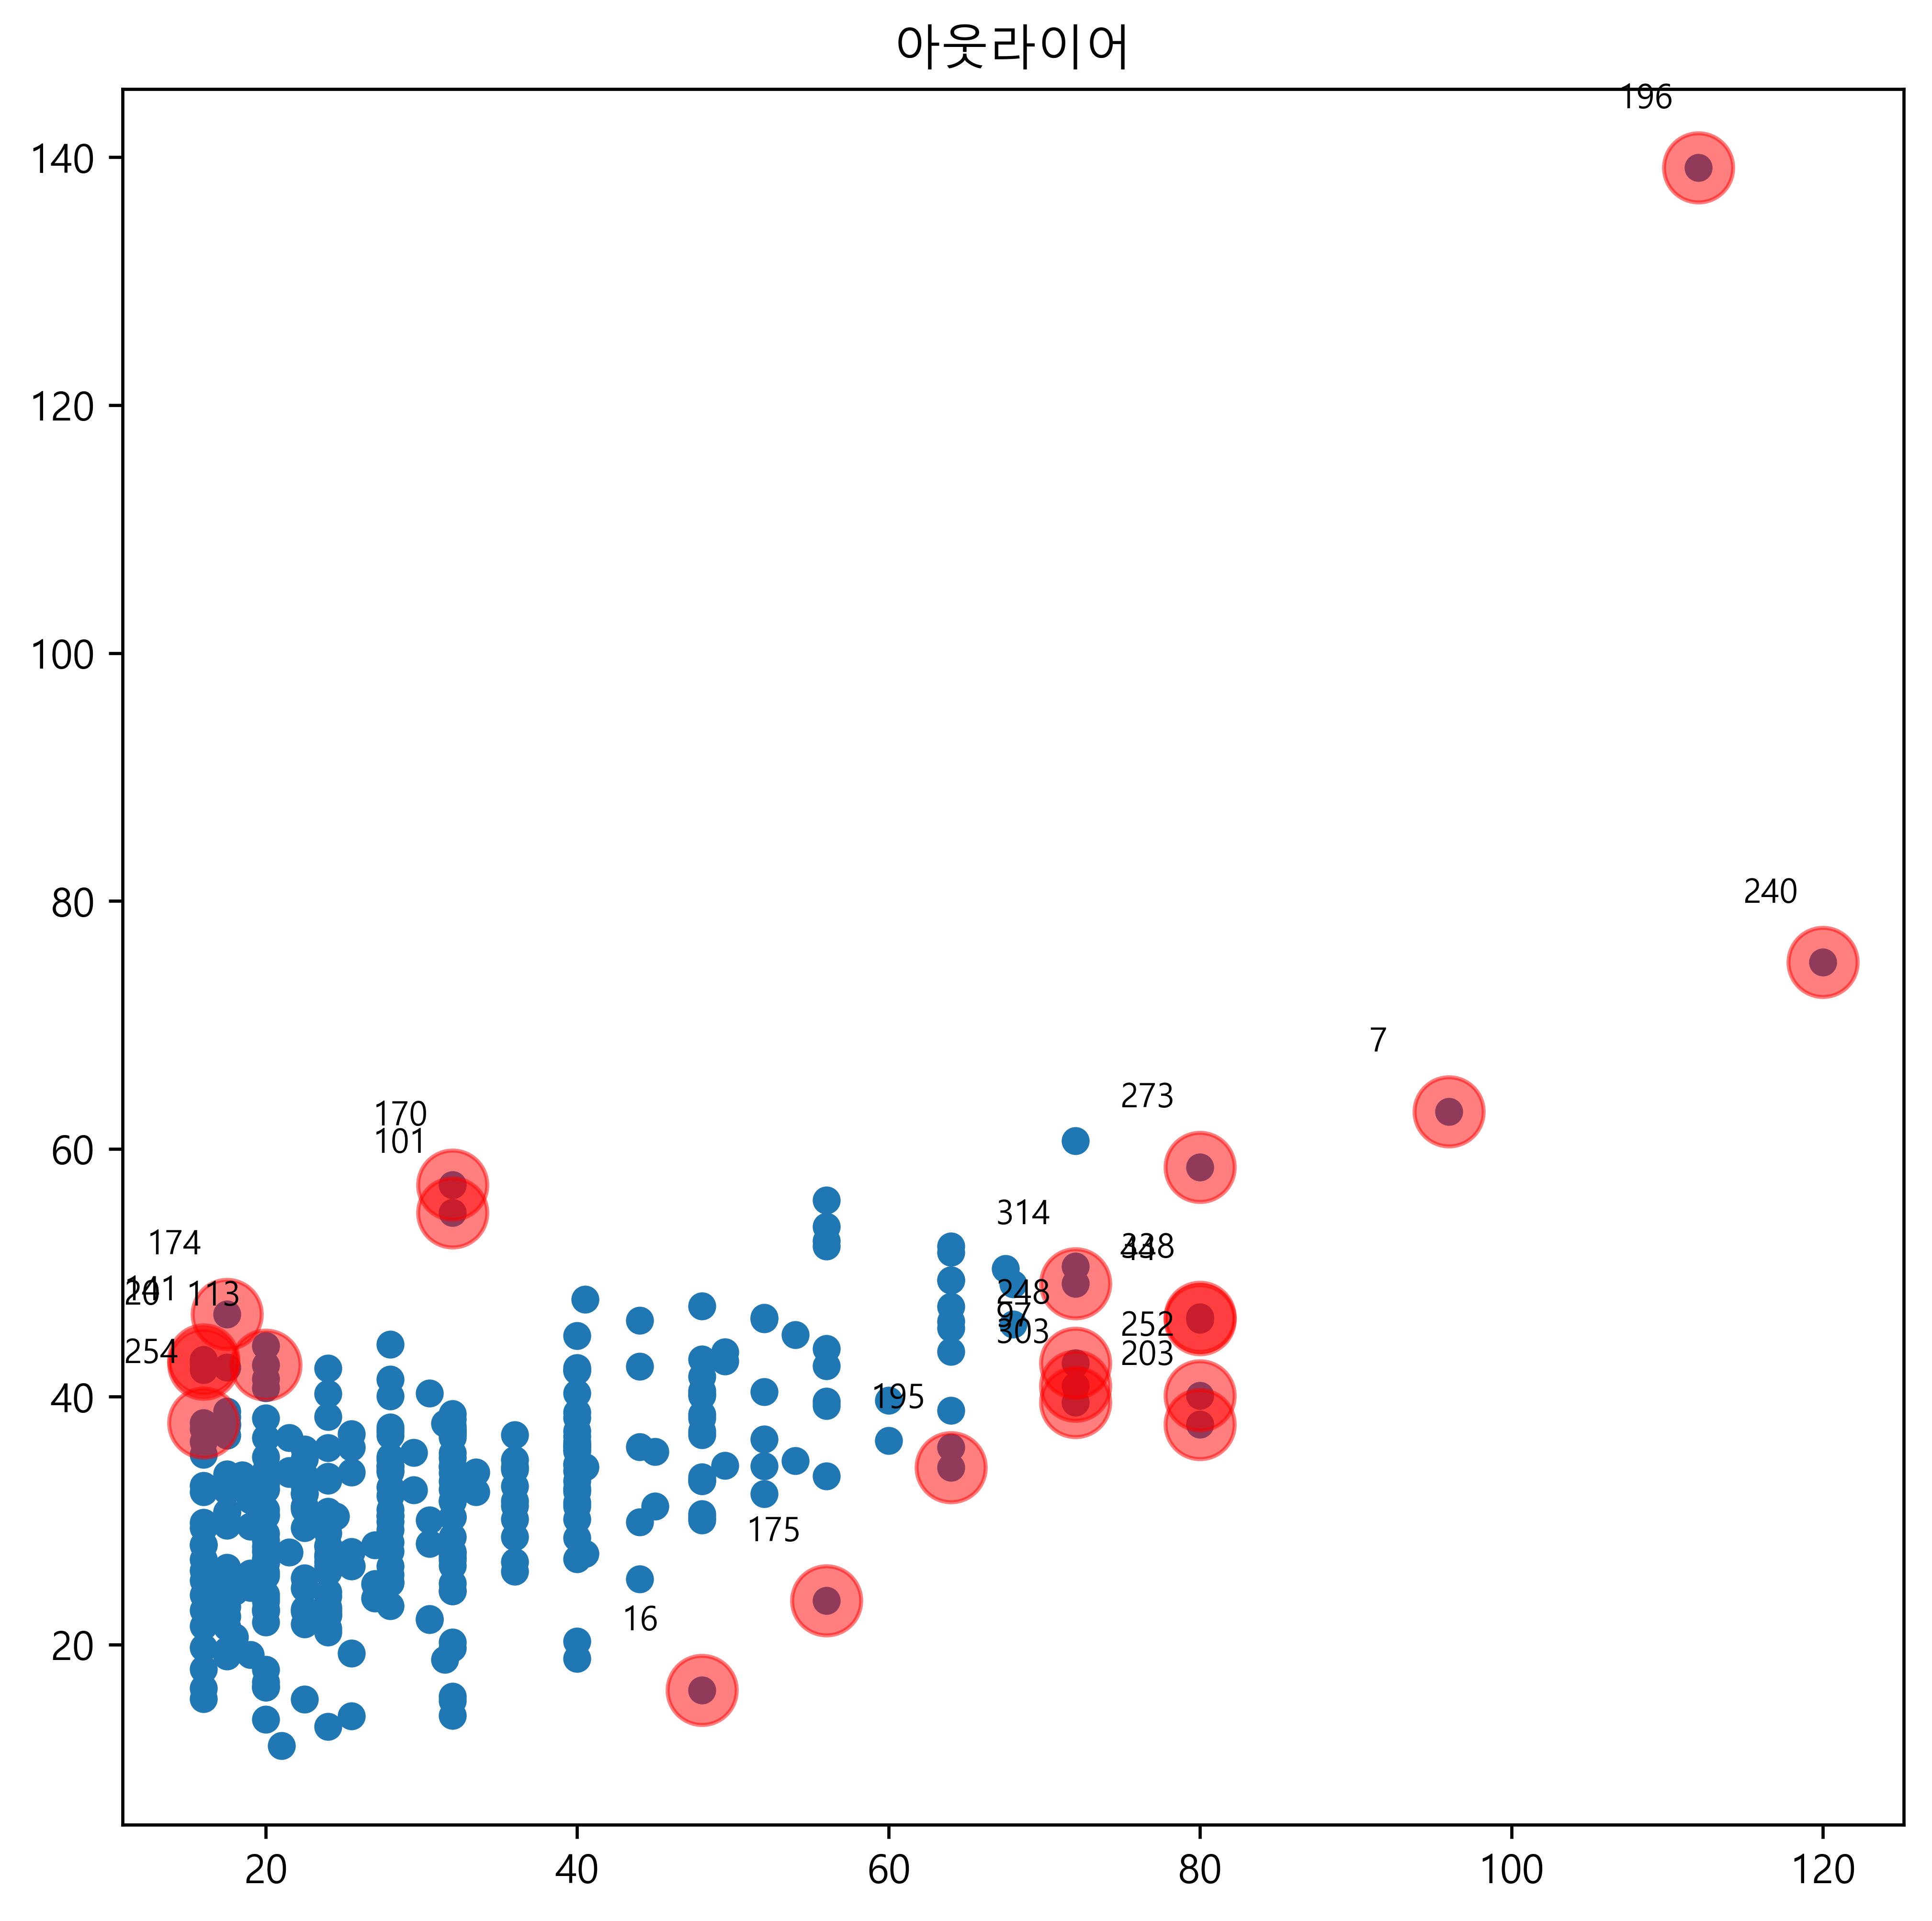

[  7  16  20  44  97 101 113 141 170 174 175 195 196 203 240 248 252 254
 273 303 314 338]


In [56]:
from statsmodels.graphics import utils

dfX0 = df_out_20.drop('value', axis=1)
dfX = sm.add_constant(dfX0)
dfy = df_out_20['value']

model_p = sm.OLS(dfy, dfX)
result_p = model_p.fit()
pred = result_p.predict(dfX)

influence_p = result_p.get_influence()
cooks_d2, pvals = influence_p.cooks_distance
K = influence_p.k_vars
fox_cr = 4 / (len(dfy) - K - 1)
idx = np.where(cooks_d2 > fox_cr)[0]

ax = plt.subplot()
plt.scatter(dfy, pred)
plt.scatter(dfy[idx], pred[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, list(zip(dfy[idx], pred[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.title("아웃라이어")
plt.show()
print(idx)

In [57]:
idx2 = list(set(range(len(dfX))).difference(idx))
len(idx2)

329

In [58]:
df_out2 = df_out_20.iloc[idx2].reset_index(drop=True)
df_out2

,age,value,follower,passes_accuracy,games_played,shotsOnTotal_goalsTotal
0,25.000000,20.0,67879,3.2985,77.6111,-1.612784
1,27.000000,32.0,740918,4.0184,101.5333,1.822336
2,24.000000,24.0,601838,13.4528,81.5444,-1.817034
3,25.000000,32.0,652886,9.1609,87.6556,0.551484
4,32.000000,32.0,11513791,6.1453,104.1444,2.104335
...,...,...,...,...,...,...
324,28.000000,44.0,1028085,4.2611,92.7000,0.448326
325,23.076923,24.0,57900,2.3642,93.0556,-0.497805
326,32.000000,22.5,8983450,8.6552,100.0556,1.152975
327,26.000000,24.0,109000,7.4315,86.3889,0.759456


In [67]:
from sklearn.model_selection import train_test_split

dfX = df_out2.drop(['value'], axis=1)
dfy = df_out2['value']
df = pd.concat([dfX, dfy], axis=1)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)

feature_names = list(dfX.columns)
feature_names = ["scale({})".format(name) for name in feature_names]

model = sm.OLS.from_formula("value ~ " + "+".join(feature_names), data=df_train)
result = model.fit()
print(result.summary())

##############################################################################
from sklearn.model_selection import KFold

scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df_ols)):
    df_train = df_ols.iloc[idx_train]
    df_test = df_ols.iloc[idx_test]
    
    model = sm.OLS.from_formula(formula, data=df_train)
    result = model.fit()
    
    pred = result.predict(df_test)
    rss = ((df_test.value - pred) ** 2).sum()
    tss = ((df_test.value - df_test.value.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
#    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
print("모델 성능 : {}".format(scores.mean()))

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     28.23
Date:                Wed, 24 Jun 2020   Prob (F-statistic):           3.77e-22
Time:                        17:27:02   Log-Likelihood:                -870.39
No. Observations:                 230   AIC:                             1753.
Df Residuals:                     224   BIC:                             1773.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

# 검증

In [62]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm

class StatsmodelsOLS(BaseEstimator, RegressorMixin):
    def __init__(self, formula):
        self.formula = formula
        self.model = None
        self.data = None
        self.result = None
        
    def fit(self, dfX, dfy):
        self.data = pd.concat([dfX, dfy], axis=1)
        self.model = smf.ols(self.formula, data=self.data)
        self.result = self.model.fit()
        
    def predict(self, new_data):
        return self.result.predict(new_data)

In [63]:
from sklearn.model_selection import cross_val_score

model = StatsmodelsOLS("value ~ scale(age) + scale(follower) + scale(passes_accuracy) + \
                       scale(games_played) + scale(shotsOnTotal_goalsTotal)")
cv = KFold(10, shuffle=True, random_state=0)
cross_val_score(model, dfX, dfy, scoring="r2", cv=cv).mean()

0.3361230223463881

# Data 가중

In [64]:
from sklearn.model_selection import train_test_split

dfX = df_out_15.drop(['value'], axis=1)
dfy = df_out_15['value']
df = pd.concat([dfX, dfy], axis=1)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)

feature_names = list(dfX.columns)
feature_names = ["scale({})".format(name) for name in feature_names]

formula = "value ~ scale(age) + scale(I(age**2)) + scale(I(age**3)) + \
            scale(follower) + scale(I(follower**2)) +\
            scale(passes_total) + scale(I(passes_total**2)) +\
            scale(passes_accuracy) + \
            scale(fouls_drawn) + \
            scale(games_lineups) + \
            scale(games_played) + \
            scale(shotsOnTotal_goalsTotal) + \
            scale(dribblesAtmptsSuc) + \
            scale(gamesApperance_sub)"

model = sm.OLS.from_formula(formula, data=df_train)
result = model.fit()
print(result.summary())

##############################################################################
from sklearn.model_selection import KFold

scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df_ols)):
    df_train = df_ols.iloc[idx_train]
    df_test = df_ols.iloc[idx_test]
    
    model = sm.OLS.from_formula(formula, data=df_train)
    result = model.fit()
    
    pred = result.predict(df_test)
    rss = ((df_test.value - pred) ** 2).sum()
    tss = ((df_test.value - df_test.value.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
#    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
print("모델 성능 : {}".format(scores.mean()))

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     13.79
Date:                Wed, 24 Jun 2020   Prob (F-statistic):           1.36e-23
Time:                        17:21:14   Log-Likelihood:                -942.83
No. Observations:                 245   AIC:                             1916.
Df Residuals:                     230   BIC:                             1968.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

# 공격수 데이터

# 높은 상관관계를 보이는 feature들의
# 다중공산성 제거를 위해 PCA 작업
1. height, weight
2. shots_total, shots_on, goals_total
3. passes_key, passes_total, goals_assists
4. duels_total, duels_won
5. dribbles_attempts, dribbles_success
6. games_appearences, substitutes_in, substitutes_bench

In [98]:
df_pca = pd.concat([df_pos_pca_hw, df_pos_pca_sg, df_pos_pca_pktga, df_pos_pca_duels, 
                    df_pos_pca_dribbles, df_pos_pca_gasub], axis=1)
df_pca

,hw,shotsOnTotal_goalsTotal,passesKeyTotal_goalsAssists,duelsWonTotal,dribblesAtmptsSuc,gamesAppearance_sub
0,0.135092,0.410180,0.247653,0.556537,0.177385,0.030469
1,0.172989,0.258458,0.495514,0.529304,0.477339,0.542955
2,0.144042,0.449352,0.546876,0.281113,0.113115,0.060079
3,0.141252,0.522966,0.538682,0.210466,0.173616,0.182433
4,0.146832,0.451450,0.444267,0.552810,0.229560,0.295547
...,...,...,...,...,...,...
92,0.030463,0.460795,0.357580,0.345001,0.054158,0.001575
93,0.167877,0.244692,0.397444,0.836112,0.776258,0.000774
94,0.041084,0.114543,0.023259,0.028809,0.000000,0.188988
95,0.126835,0.333166,0.842611,0.388996,0.482005,0.430106


In [99]:
df_pca.corr()[df_pca.corr() > 0.7]

,hw,shotsOnTotal_goalsTotal,passesKeyTotal_goalsAssists,duelsWonTotal,dribblesAtmptsSuc,gamesAppearance_sub
hw,1.0,NaN,NaN,NaN,NaN,NaN
shotsOnTotal_goalsTotal,NaN,1.0,NaN,NaN,NaN,NaN
passesKeyTotal_goalsAssists,NaN,NaN,1.0,NaN,NaN,NaN
duelsWonTotal,NaN,NaN,NaN,1.0,NaN,NaN
dribblesAtmptsSuc,NaN,NaN,NaN,NaN,1.0,NaN
gamesAppearance_sub,NaN,NaN,NaN,NaN,NaN,1.0


# OLS - 1차

In [26]:
from sklearn.model_selection import train_test_split

#df_ols = df_out_14_2_5
dfX = df_ols.drop(['value'], axis=1)
dfy = df_ols['value']
df = pd.concat([dfX, dfy], axis=1)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)

feature_names = list(dfX.columns)
feature_names = ["scale({})".format(name) for name in feature_names]

#formula = "value ~ " + "+".join(feature_names)

model = sm.OLS.from_formula("value ~ " + "+".join(feature_names), data=df_train)
result = model.fit()
print(result.summary())

##############################################################################
from sklearn.model_selection import KFold

scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df_ols)):
    df_train = df_ols.iloc[idx_train]
    df_test = df_ols.iloc[idx_test]
    
    model = sm.OLS.from_formula("value ~ " + "+".join(feature_names), data=df_train)
    result = model.fit()
    
    pred = result.predict(df_test)
    rss = ((df_test.value - pred) ** 2).sum()
    tss = ((df_test.value - df_test.value.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
print("모델 성능 : {}".format(scores.mean()))

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     5.525
Date:                Wed, 24 Jun 2020   Prob (F-statistic):           7.71e-07
Time:                        17:00:35   Log-Likelihood:                -276.09
No. Observations:                  67   AIC:                             604.2
Df Residuals:                      41   BIC:                             661.5
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

# OLS - 17차

# P값 모두 0.05 미만 

In [188]:
df_ols_16 = df_ols_15.drop(['cards_red'], axis=1)
len(df_ols_15.columns), len(df_ols_16.columns)

(11, 10)

In [189]:
from sklearn.model_selection import train_test_split

df_ols = df_ols_16
dfX = df_ols.drop(['value'], axis=1)
dfy = df_ols['value']
df = pd.concat([dfX, dfy], axis=1)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)

feature_names = list(dfX.columns)
feature_names = ["scale({})".format(name) for name in feature_names]

#formula = "value ~ " + "+".join(feature_names)

model = sm.OLS.from_formula("value ~ " + "+".join(feature_names), data=df_train)
result = model.fit()
print(result.summary())




##############################################################################
from sklearn.model_selection import KFold

scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df_ols)):
    df_train = df_ols.iloc[idx_train]
    df_test = df_ols.iloc[idx_test]
    
    model = sm.OLS.from_formula("value ~ " + "+".join(feature_names), data=df_train)
    result = model.fit()
    
    pred = result.predict(df_test)
    rss = ((df_test.value - pred) ** 2).sum()
    tss = ((df_test.value - df_test.value.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
#    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
print("모델 성능 : {}".format(scores.mean()))

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     11.94
Date:                Mon, 22 Jun 2020   Prob (F-statistic):           2.57e-10
Time:                        18:11:21   Log-Likelihood:                -290.00
No. Observations:                  67   AIC:                             600.0
Df Residuals:                      57   BIC:                             622.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

# 가중치

In [77]:
from sklearn.model_selection import train_test_split

df_ols = df_ols_16
dfX = df_ols.drop(['value'], axis=1)
dfy = df_ols['value']
df = pd.concat([dfX, dfy], axis=1)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)

feature_names = list(dfX.columns)
feature_names = ["scale({})".format(name) for name in feature_names]

formula = "value ~ scale(age) + scale(I(age**2)) + scale(I(age**3)) + \
            scale(follower) + \
            scale(passes_accuracy) + \
            scale(penalty_won) + \
            scale(games_lineups) + \
            scale(substitutes_out) + \
            scale(games_played) + \
            scale(shotsOnTotal_goalsTotal) + \
            scale(gamesAppearance_sub)"

model = sm.OLS.from_formula(formula, data=df_train)
result = model.fit()
print(result.summary())


##############################################################################
from sklearn.model_selection import KFold

scores = np.zeros(5)
for i, (idx_train, idx_test) in enumerate(cv.split(df_ols)):
    df_train = df_ols.iloc[idx_train]
    df_test = df_ols.iloc[idx_test]
    
    model = sm.OLS.from_formula(formula, data=df_train)
    result = model.fit()
    
    pred = result.predict(df_test)
    rss = ((df_test.value - pred) ** 2).sum()
    tss = ((df_test.value - df_test.value.mean())** 2).sum()
    rsquared = 1 - rss / tss
    
    scores[i] = rsquared
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))
print("모델 성능 : {}".format(scores.mean()))

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     16.87
Date:                Wed, 24 Jun 2020   Prob (F-statistic):           6.83e-14
Time:                        17:04:09   Log-Likelihood:                -276.06
No. Observations:                  67   AIC:                             576.1
Df Residuals:                      55   BIC:                             602.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   